# Finetunen Elkulako/cryptobert Modell

## Import

In [1]:
import os
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import DebertaV2Tokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer, EarlyStoppingCallback
import evaluate
import numpy as np
import torch
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
import transformers
import warnings

c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Cuda pruefen
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [3]:
DATA_PATH = '../../data/processed/'

In [4]:
# Trainingsdaten (Comments)
df_all_comments = pd.read_csv(os.path.join(DATA_PATH, 'training_data_comments.csv'))
df_all_comments = df_all_comments[['text', 'label']].dropna()
df_all_comments['label'] = df_all_comments['label'].astype(int)

# Testdaten (Comments)
df_test_comments = pd.read_csv(os.path.join(DATA_PATH, 'test_data_comments.csv'))
df_test_comments = df_test_comments[['text', 'label']].dropna()
df_test_comments['label'] = df_test_comments['label'].astype(int)

print(f"✅ Trainingsdatensatz: {len(df_all_comments)} Kommentare")
print(df_all_comments['label'].value_counts())

print(f"\n✅ Testdatensatz: {len(df_test_comments)} Kommentare")
print(df_test_comments['label'].value_counts())

✅ Trainingsdatensatz: 599975 Kommentare
label
2    305079
1    239043
0     55853
Name: count, dtype: int64

✅ Testdatensatz: 999 Kommentare
label
0    333
1    333
2    333
Name: count, dtype: int64


## Train-Test-Split

In [5]:
# 📌 Stratifiziertes Downsampling (1.000 pro Klasse)
df_trainval = (
    df_all_comments
    .groupby("label", group_keys=False)
    .apply(lambda x: x.sample(n=1000, random_state=42))
    .reset_index(drop=True)
)

# ✅ Split in Train (80%) und Val (20%)
train_df, val_df = train_test_split(
    df_trainval,
    test_size=0.2,
    stratify=df_trainval["label"],
    random_state=42
)

# ✅ Testdaten: vorhandene manuell gelabelte Kommentare
df_test_comments = df_test_comments.reset_index(drop=True)
df_test_comments["text"] = df_test_comments["text"].astype(str)

# ✅ Indizes zurücksetzen
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# 📊 Ausgabe
print("✅ Finaler Datensplit:")
print(f"- Train: {len(train_df)}")
print(f"- Val:   {len(val_df)}")
print(f"- Test:  {len(df_test_comments)}")
print("🔍 Labelverteilung (Train):\n", train_df["label"].value_counts())

✅ Finaler Datensplit:
- Train: 2400
- Val:   600
- Test:  999
🔍 Labelverteilung (Train):
 label
2    800
0    800
1    800
Name: count, dtype: int64


C:\Users\hp\AppData\Local\Temp\ipykernel_19780\697304940.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_all_comments


## Weighted Loss

ab hier wird die class weight loss geaednert

In [6]:
class WeightedLossTrainer(Trainer):
    def __init__(self, *args, loss_fn=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_fn = loss_fn

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):  # ✅ **kwargs ergänzt
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = self.loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss


In [7]:
# Manuelle Class Weights – hier z. B. stärkerer Fokus auf bearish
weights_tensor = torch.tensor([2.0, 1.0, 3.0], dtype=torch.float)
device = "cuda" if torch.cuda.is_available() else "cpu"

loss_fn = torch.nn.CrossEntropyLoss(weight=weights_tensor.to(device))


## Modelltraining

Modell und Tokenizer laden

In [8]:
EXPERIMENTS_BASE_PATH = "../../models/experiments/"

MODEL_PATHS = {
    "cryptobert_comments": os.path.join(EXPERIMENTS_BASE_PATH, "cryptobert_comments")
}

for path in MODEL_PATHS.values():
    os.makedirs(path, exist_ok=True)


In [9]:
# Modellname direkt von Hugging Face
model_name = "ElKulako/cryptobert"

# Tokenizer und Modell laden
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

In [10]:
def tokenize_function(batch):
    tokenized = tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=256
    )
    tokenized["label"] = batch["label"]
    return tokenized


Tokenisierung der Splits

In [11]:
train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(df_test_comments)

train_ds = train_ds.map(tokenize_function, batched=True)
val_ds = val_ds.map(tokenize_function, batched=True)
test_ds = test_ds.map(tokenize_function, batched=True)

Map: 100%|██████████| 999/999 [00:00<00:00, 12970.75 examples/s]


In [12]:
train_ds = train_ds.rename_column("label", "labels")
val_ds = val_ds.rename_column("label", "labels")
test_ds = test_ds.rename_column("label", "labels")


# Format setzen
train_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


Metriken

In [13]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="macro")
    }


Traininsargumente und Trainer

In [14]:
results = {}
lrs = [2e-5, 1e-5, 5e-6, 3e-6, 1e-6]

for lr in lrs:
    print(f"Starte Training für learning_rate = {lr}")

      # Modell bei jedem Run neu laden!
    model = AutoModelForSequenceClassification.from_pretrained(
        "ElKulako/cryptobert",
        num_labels=3
    )

    output_dir = os.path.join(MODEL_PATHS["cryptobert_comments"], f"finetuned_lr_{lr}")
    logging_dir = os.path.join("../../logs/cryptobert_comments", f"lr_{lr}")
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(logging_dir, exist_ok=True)

    training_args = TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=lr,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=10,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        logging_dir=logging_dir,
        logging_strategy="epoch",
        report_to="none",
        remove_unused_columns=False,
        disable_tqdm=True
    )

    trainer = WeightedLossTrainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        tokenizer=tokenizer,
        eval_dataset=val_ds,
        compute_metrics=compute_metrics,
        loss_fn=loss_fn,    
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )



    start = time.time()
    trainer.train()
    end = time.time()

    logs = trainer.state.log_history
    epoch_logs = [log for log in logs if "eval_f1" in log]
    df = pd.DataFrame(epoch_logs)[["epoch", "eval_f1"]]
    df["learning_rate"] = lr

    results[lr] = {
        "f1_curve": df,
        "best_f1": df["eval_f1"].max(),
        "trainer": trainer
    }
    print(f"Training für learning_rate = {lr} abgeschlossen in {end - start:.2f} Sekunden.")

Starte Training für learning_rate = 2e-05


c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\hp\AppData\Local\Temp\ipykernel_19780\3133020267.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


{'loss': 0.5651, 'grad_norm': 20.53203582763672, 'learning_rate': 1.8e-05, 'epoch': 1.0}
{'eval_loss': 0.43310683965682983, 'eval_accuracy': 0.73, 'eval_f1': 0.6907808784059362, 'eval_runtime': 4.7281, 'eval_samples_per_second': 126.9, 'eval_steps_per_second': 15.863, 'epoch': 1.0}
{'loss': 0.3419, 'grad_norm': 187.22764587402344, 'learning_rate': 1.6000000000000003e-05, 'epoch': 2.0}
{'eval_loss': 0.577396035194397, 'eval_accuracy': 0.7316666666666667, 'eval_f1': 0.7129753645636446, 'eval_runtime': 5.1664, 'eval_samples_per_second': 116.136, 'eval_steps_per_second': 14.517, 'epoch': 2.0}
{'loss': 0.1908, 'grad_norm': 8.39767837524414, 'learning_rate': 1.4e-05, 'epoch': 3.0}
{'eval_loss': 0.9111366868019104, 'eval_accuracy': 0.725, 'eval_f1': 0.7278239350142858, 'eval_runtime': 5.3669, 'eval_samples_per_second': 111.796, 'eval_steps_per_second': 13.975, 'epoch': 3.0}
{'loss': 0.0756, 'grad_norm': 0.10187384486198425, 'learning_rate': 1.2e-05, 'epoch': 4.0}
{'eval_loss': 1.2462016344070

c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\hp\AppData\Local\Temp\ipykernel_19780\3133020267.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


{'loss': 0.5131, 'grad_norm': 10.249655723571777, 'learning_rate': 9e-06, 'epoch': 1.0}
{'eval_loss': 0.4130532145500183, 'eval_accuracy': 0.7333333333333333, 'eval_f1': 0.6902551120436025, 'eval_runtime': 5.4799, 'eval_samples_per_second': 109.49, 'eval_steps_per_second': 13.686, 'epoch': 1.0}
{'loss': 0.3414, 'grad_norm': 18.18508529663086, 'learning_rate': 8.000000000000001e-06, 'epoch': 2.0}
{'eval_loss': 0.43689894676208496, 'eval_accuracy': 0.7516666666666667, 'eval_f1': 0.7335408395896388, 'eval_runtime': 5.5231, 'eval_samples_per_second': 108.635, 'eval_steps_per_second': 13.579, 'epoch': 2.0}
{'loss': 0.2299, 'grad_norm': 22.72601890563965, 'learning_rate': 7e-06, 'epoch': 3.0}
{'eval_loss': 0.5760477185249329, 'eval_accuracy': 0.7683333333333333, 'eval_f1': 0.7623782936204986, 'eval_runtime': 5.5164, 'eval_samples_per_second': 108.766, 'eval_steps_per_second': 13.596, 'epoch': 3.0}
{'loss': 0.1356, 'grad_norm': 11.810227394104004, 'learning_rate': 6e-06, 'epoch': 4.0}
{'eval_

c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\hp\AppData\Local\Temp\ipykernel_19780\3133020267.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


{'loss': 0.4813, 'grad_norm': 35.58465576171875, 'learning_rate': 4.5e-06, 'epoch': 1.0}
{'eval_loss': 0.4064965844154358, 'eval_accuracy': 0.7433333333333333, 'eval_f1': 0.7021877474089608, 'eval_runtime': 6.0732, 'eval_samples_per_second': 98.795, 'eval_steps_per_second': 12.349, 'epoch': 1.0}
{'loss': 0.3694, 'grad_norm': 11.221257209777832, 'learning_rate': 4.000000000000001e-06, 'epoch': 2.0}
{'eval_loss': 0.40172290802001953, 'eval_accuracy': 0.7716666666666666, 'eval_f1': 0.7522855477180203, 'eval_runtime': 6.185, 'eval_samples_per_second': 97.009, 'eval_steps_per_second': 12.126, 'epoch': 2.0}
{'loss': 0.297, 'grad_norm': 34.2761344909668, 'learning_rate': 3.5e-06, 'epoch': 3.0}
{'eval_loss': 0.4516412317752838, 'eval_accuracy': 0.7666666666666667, 'eval_f1': 0.7539772032876356, 'eval_runtime': 6.1956, 'eval_samples_per_second': 96.843, 'eval_steps_per_second': 12.105, 'epoch': 3.0}
{'loss': 0.2396, 'grad_norm': 11.476981163024902, 'learning_rate': 3e-06, 'epoch': 4.0}
{'eval_l

c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\hp\AppData\Local\Temp\ipykernel_19780\3133020267.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


{'loss': 0.4727, 'grad_norm': 64.7245101928711, 'learning_rate': 2.7e-06, 'epoch': 1.0}
{'eval_loss': 0.40415364503860474, 'eval_accuracy': 0.74, 'eval_f1': 0.6975113190763472, 'eval_runtime': 6.3255, 'eval_samples_per_second': 94.855, 'eval_steps_per_second': 11.857, 'epoch': 1.0}
{'loss': 0.3945, 'grad_norm': 44.933128356933594, 'learning_rate': 2.4000000000000003e-06, 'epoch': 2.0}
{'eval_loss': 0.39311787486076355, 'eval_accuracy': 0.765, 'eval_f1': 0.7437821875585596, 'eval_runtime': 6.3252, 'eval_samples_per_second': 94.859, 'eval_steps_per_second': 11.857, 'epoch': 2.0}
{'loss': 0.3456, 'grad_norm': 53.49689865112305, 'learning_rate': 2.1e-06, 'epoch': 3.0}
{'eval_loss': 0.4173688292503357, 'eval_accuracy': 0.765, 'eval_f1': 0.7466732769704011, 'eval_runtime': 6.3268, 'eval_samples_per_second': 94.834, 'eval_steps_per_second': 11.854, 'epoch': 3.0}
{'loss': 0.3047, 'grad_norm': 17.016803741455078, 'learning_rate': 1.8e-06, 'epoch': 4.0}
{'eval_loss': 0.44284820556640625, 'eval_a

c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\hp\AppData\Local\Temp\ipykernel_19780\3133020267.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


{'loss': 0.4719, 'grad_norm': 102.32600402832031, 'learning_rate': 9e-07, 'epoch': 1.0}
{'eval_loss': 0.3913396894931793, 'eval_accuracy': 0.7516666666666667, 'eval_f1': 0.7191416485640313, 'eval_runtime': 6.2249, 'eval_samples_per_second': 96.387, 'eval_steps_per_second': 12.048, 'epoch': 1.0}
{'loss': 0.4355, 'grad_norm': 34.68019485473633, 'learning_rate': 8e-07, 'epoch': 2.0}
{'eval_loss': 0.3861194849014282, 'eval_accuracy': 0.7583333333333333, 'eval_f1': 0.7297610137597457, 'eval_runtime': 6.2292, 'eval_samples_per_second': 96.321, 'eval_steps_per_second': 12.04, 'epoch': 2.0}
{'loss': 0.4199, 'grad_norm': 60.99127197265625, 'learning_rate': 7e-07, 'epoch': 3.0}
{'eval_loss': 0.38499853014945984, 'eval_accuracy': 0.7616666666666667, 'eval_f1': 0.7377444334890995, 'eval_runtime': 6.2174, 'eval_samples_per_second': 96.504, 'eval_steps_per_second': 12.063, 'epoch': 3.0}
{'loss': 0.3911, 'grad_norm': 35.093666076660156, 'learning_rate': 6e-07, 'epoch': 4.0}
{'eval_loss': 0.3958489596

## Evaluation

Plott fuer die Lernkurve

C:\Users\hp\AppData\Local\Temp\ipykernel_19780\460586369.py:12: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


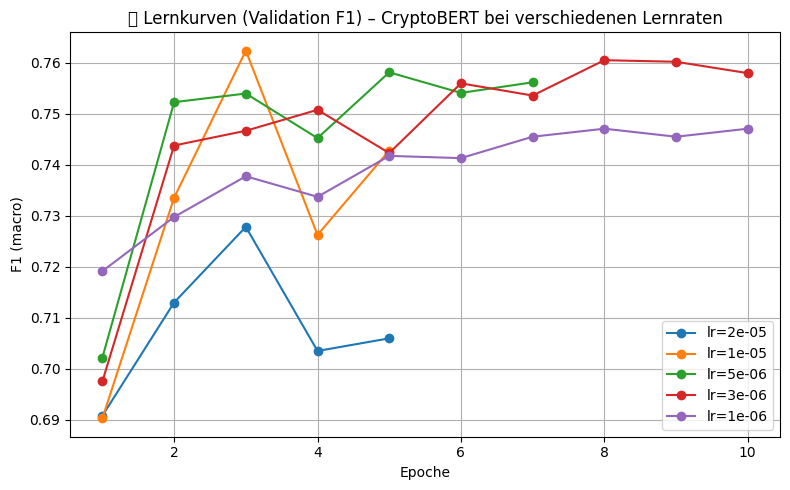

In [15]:
plt.figure(figsize=(8, 5))

for lr, data in results.items():
    df = data["f1_curve"]
    plt.plot(df["epoch"], df["eval_f1"], marker="o", label=f"lr={lr}")

plt.title("📈 Lernkurven (Validation F1) – CryptoBERT bei verschiedenen Lernraten")
plt.xlabel("Epoche")
plt.ylabel("F1 (macro)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
for lr, res in results.items():
    print(f"lr={lr}: best_f1={res['best_f1']:.4f}")


lr=2e-05: best_f1=0.7278
lr=1e-05: best_f1=0.7624
lr=5e-06: best_f1=0.7581
lr=3e-06: best_f1=0.7605
lr=1e-06: best_f1=0.7471


In [17]:
# Beste Lernrate bestimmen
best_lr = max(results.items(), key=lambda x: x[1]["best_f1"])[0]
best_trainer = results[best_lr]["trainer"]

print(f"\n🏆 Beste Lernrate: {best_lr} mit F1 = {results[best_lr]['best_f1']:.4f}")



🏆 Beste Lernrate: 1e-05 mit F1 = 0.7624


Evaluation im finalen Testsplit

In [18]:
from sklearn.metrics import classification_report, f1_score, cohen_kappa_score

# Vorhersage
test_results = best_trainer.predict(test_ds)

# Vorhersage & Wahre Labels
y_pred = test_results.predictions.argmax(axis=1)
y_true = test_results.label_ids

# Kein Mapping nötig – Test- und Trainingsdaten sind synchron
f1_macro = f1_score(y_true, y_pred, average="macro")
kappa = cohen_kappa_score(y_true, y_pred)

# Ausgabe
print("\nEvaluation auf Testset:")
print("F1-Score (macro):", round(f1_macro, 4))
print("Cohen’s Kappa:   ", round(kappa, 4))
print("\nKlassifikationsreport:")
print(classification_report(y_true, y_pred))



Evaluation auf Testset:
F1-Score (macro): 0.9199
Cohen’s Kappa:    0.8814

Klassifikationsreport:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       333
           1       0.94      0.83      0.88       333
           2       0.88      0.95      0.92       333

    accuracy                           0.92       999
   macro avg       0.92      0.92      0.92       999
weighted avg       0.92      0.92      0.92       999

